# EDA: 데이터의 구조적 특징 파악

키워드는 훈련 데이터와 테스트 데이터 간의 **분포 차이**이다. 이를 바탕으로 EDA를 통해 훈련 데이터의 분포가 테스트 데이터의 분포와 확연히 달라 모델의 일반화 성능을 저하시킬 수 있는 요소가 있는지 확인한다.

1. 훈련 데이터 내 클래스 불균형 여부 확인

2. 훈련 vs. 테스트 텍스트 길이 분포 확인

3. 훈련 데이터 내 클래스별 상위 5개 대화 확인

## 라이브러리 호출 & 경로 지정

In [1]:
# 기타 라이브러리
import pandas as pd
import numpy as np
import json
import os
import random

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# # 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 경로 설정
HOME_DIR = os.path.join(os.getenv("HOME"), "work/dlthon/")
DATA_DIR = os.path.join(HOME_DIR, "dktc/data/")

TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.json")

In [3]:
# 클래스 정의
CLASS_NAMES = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반대화']

## 데이터 로드

In [4]:
# 데이터셋 로드
train_df = pd.read_csv(TRAIN_PATH) # 훈련 데이터
print(f" Train data loaded: {train_df.shape}")
print(f"\nFirst 5 rows:")
print(train_df.head())

with open(TEST_PATH, 'r', encoding='utf-8') as f: # 테스트 데이터
    test_data = json.load(f)

test_indices = list(test_data.keys())
test_texts = [test_data[idx]['text'] for idx in test_indices]
test_df = pd.DataFrame({
    'file_name': test_indices,
    'text': test_texts
})
print(f"\n Test data loaded: {test_df.shape}")

 Train data loaded: (3950, 3)

First 5 rows:
   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...

 Test data loaded: (500, 2)


In [5]:
# 클래스 매핑
# CSV에서 class가 문자열로 로드될 수 있으므로 정수로 변환
if train_df['class'].dtype == 'object' or train_df['class'].dtype == 'str':
    print("⚠️ Converting 'class' column from string to integer...")
    
    # 클래스 이름 → 숫자 매핑 (일반 대화 4 추가)
    class_mapping = {
        '협박 대화': 0,
        '갈취 대화': 1,
        '직장 내 괴롭힘 대화': 2,
        '기타 괴롭힘 대화': 3,
        '일반 대화': 4,
        # 숫자 문자열도 처리
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4
    }
    
    train_df['class'] = train_df['class'].map(class_mapping)
    
    # 매핑 안 된 값 확인
    if train_df['class'].isna().any():
        print(f"⚠️ Warning: {train_df['class'].isna().sum()} unmapped class values")
        # 원본 데이터 확인을 위해 TRAIN_PATH 다시 읽기 시도
        raw_classes = pd.read_csv(TRAIN_PATH)['class'].unique() if 'TRAIN_PATH' in locals() else "Unknown"
        print(f"Unique values in original data: {raw_classes}")
    else:
        print("✅ Class column converted to integer successfully")

# 최종 타입 확인 및 변환
train_df['class'] = train_df['class'].fillna(-1).astype(int) # 결측치 대비
print(f"Class column dtype: {train_df['class'].dtype}")
print(f"Unique classes in train_df: {sorted(train_df['class'].unique())}") # 0~4까지 있는지 확인
print(f"\n✅ Train data loaded: {train_df.shape}")

# 테스트 데이터
with open(TEST_PATH, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

test_indices = list(test_data.keys())
test_texts = [test_data[idx]['text'] for idx in test_indices]
test_df = pd.DataFrame({
    'file_name': test_indices,
    'text': test_texts
})
print(f"\n✅ Test data loaded: {test_df.shape}")

print("\n" + "="*60)

⚠️ Converting 'class' column from string to integer...
✅ Class column converted to integer successfully
Class column dtype: int64
Unique classes in train_df: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

✅ Train data loaded: (3950, 3)

✅ Test data loaded: (500, 2)



## 훈련 데이터 내 클래스 불균형 여부 확인


1. Class Distribution
----------------------------------------
  Class 0 (협박): 896 samples (22.7%)
  Class 1 (갈취): 981 samples (24.8%)
  Class 2 (직장내괴롭힘): 979 samples (24.8%)
  Class 3 (기타괴롭힘): 1094 samples (27.7%)


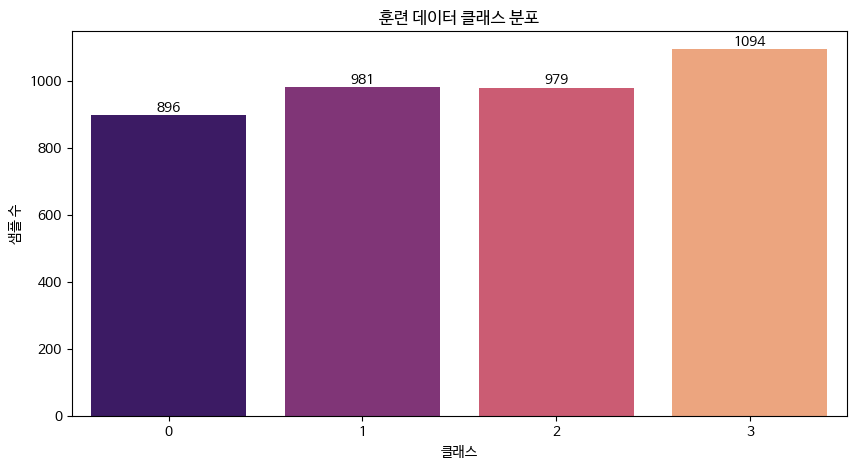

In [6]:
# Train 내 클래스 분포 확인 (Class 0~4)
class_counts = train_df['class'].value_counts().sort_index()
print("\n1. Class Distribution")
print("-" * 40)
for class_id, count in class_counts.items():
    name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else "Unknown"
    print(f"  Class {class_id} ({name}): {count} samples ({count/len(train_df)*100:.1f}%)")


# # 분포 시각화
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=train_df['class'], palette='magma')

plt.title("훈련 데이터 클래스 분포")
plt.xlabel("클래스")
plt.ylabel("샘플 수")

# 각 바 위에 숫자 표시
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10)

plt.show()

## 훈련 vs. 테스트 텍스트 길이 분포 확인

In [7]:
# train 텍스트 통계
train_df['text_length'] = train_df['conversation'].apply(len)
train_df['turn_count'] = train_df['conversation'].apply(lambda x: x.count('\n') + 1)

print("\n Train Text Statistics")
print("-" * 40)
print(train_df[['text_length', 'turn_count']].describe().iloc[1:])


 Train Text Statistics
----------------------------------------
      text_length  turn_count
mean   226.570886   10.357722
std    104.560310    1.181603
min     41.000000    5.000000
25%    156.000000   10.000000
50%    203.000000   10.000000
75%    270.000000   11.000000
max    874.000000   25.000000


In [8]:
# test 텍스트 통계
test_df['text_length'] = test_df['text'].apply(len)
test_df['turn_count'] = test_df['text'].apply(lambda x: x.count('\n') + 1)

print("\nTest Text Statistics")
print("-" * 40)
print(test_df[['text_length', 'turn_count']].describe().iloc[1:])


Test Text Statistics
----------------------------------------
      text_length  turn_count
mean   213.626000     1.04800
std    101.240473     0.21398
min     68.000000     1.00000
25%    143.000000     1.00000
50%    189.000000     1.00000
75%    253.500000     1.00000
max    722.000000     2.00000


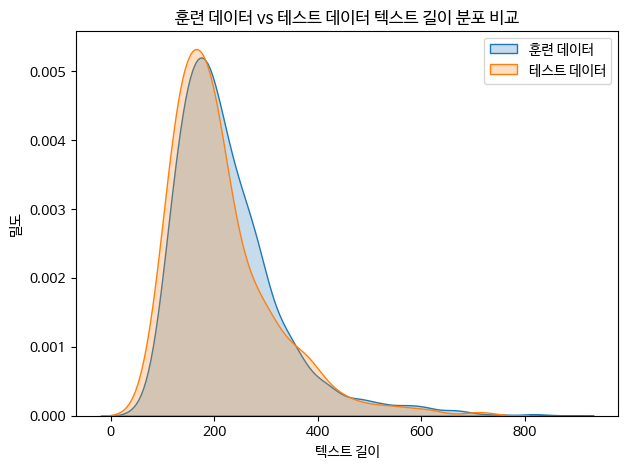

In [9]:
# 길이 계산 (없다면 추가)
train_df['text_length'] = train_df['conversation'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(7,5))
sns.kdeplot(train_df['text_length'], label='훈련 데이터', fill=True)
sns.kdeplot(test_df['text_length'], label='테스트 데이터', fill=True)

plt.title("훈련 데이터 vs 테스트 데이터 텍스트 길이 분포 비교")
plt.xlabel("텍스트 길이")
plt.ylabel("밀도")
plt.legend()
plt.show()

## 훈련 데이터 내 클래스별 상위 5개 대화 확인

In [11]:
train_df[train_df['class'] == 0].head() # 상위 5개 협박 대화 출력

,idx,class,conversation,text_length,turn_count
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,242,10
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,188,10
12,12,0,네네 무슨 일 때문에 전화주셨나요?\n우리 애가 지우개 하나 훔친거 가지고 애들 앞...,393,10
20,20,0,너가 민수라는 남자 제자니?\n네 맞는데요 왜 그러시죠? 혹시 저희 선생님께 무슨 ...,315,10
23,23,0,나좀 제발 그만 따라다녀.부탁이야\n너 만나려면 널 찾아가야될거아냐\n우리 헤어졌자...,272,10


In [12]:
train_df[train_df['class'] == 1].head() # 상위 5개 갈취 대화 출력

,idx,class,conversation,text_length,turn_count
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,115,11
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,460,12
9,9,1,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...,212,10
10,10,1,네 뭐 드릴까요?\n말보르 레드 하나.\n네. 여기요!\n여기 사장은 없어?\n네 ...,210,12
13,13,1,형! 형! 돈좀있어?\n저 저요.?\n여기 형말고 누가 있어? 형 얼마 있어?\n저...,247,10


In [13]:
train_df[train_df['class'] == 2].head() # 상위 5개 직장 내 괴롭힘 대화 출력

,idx,class,conversation,text_length,turn_count
5,5,2,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....,346,10
11,11,2,이대리 오늘 도대체 뭘한거야?\n창고정리도 하고 바닥도 청소했습니다\n이게 한거니?...,156,10
14,14,2,김사원\n대리님 왜 그러세요?\n이거 오늘까지 제출해야 하는데 좀 해줄래?\n네? ...,172,10
19,19,2,나씨 정수기 물탱크 좀 갈아주시겠어요?\n싫습니다. 물 저만 마시는 것도 아닌데 매...,271,10
36,36,2,나이가 몇인데 내가 이런 것까지 일러줘야돼?\n죄송합니다\n기본적인 것도 탑재가 안...,194,10


In [14]:
train_df[train_df['class'] == 3].head() # 상위 5개 기타 괴롭힘 대화 출력

,idx,class,conversation,text_length,turn_count
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,218,10
6,6,3,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...,236,12
7,7,3,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...,365,11
8,8,3,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...,150,10
18,18,3,야 너이마빡에 빛이난다\n어?\n야 한대만 때려보자 퍽\n아 흑 왜그래 \n아팠어?...,156,10
